# IMPORTS

In [112]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
basedir = 'C:\\Users\\rpetr\\OneDrive\\Desktop\\DISS_CODE\\ms2ldaviz\\ms2ldaviz'
sys.path.append(basedir)
import django
import json
django.setup()
from basicviz.models import Experiment, Alpha, Mass2MotifInstance, FeatureInstance, Feature, Document, Mass2Motif, DocumentMass2Motif, FeatureMass2MotifInstance
import numpy as np
import pylab as plt
import csv
from scipy.special import polygamma as pg
from scipy.special import psi as psi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VARIABLES

In [80]:
experiment_id=190 #this has 500 unique topics and 27923 words
experiment = Experiment.objects.get(id=experiment_id)
min_prob_beta = 1e-3
SMALL_NUMBER = 1e-100

# CORPUS (features for 3 documents in experiment 190)

In [7]:
#first we get all the words (features) in the vocab
features = Feature.objects.filter(experiment_id=experiment)
experiment_words = []
for f in features:
     if f.id not in experiment_words: #not really necessary since it is a primary key, but just in case
        experiment_words.append(f.id)
#checked the length of words and corresponds to database

In [13]:
#get the unique words for our experiment
unique_words = {}
index = 0
for word in experiment_words:
    if word not in unique_words.keys():
        unique_words.update({word:index})
        index+=1
#checked the dictionary keys

In [179]:
#get the unique documents for our experiment
document_id_list = [269317, 269318, 269319]
unique_docs = {}
index = 0 
for doc in document_id_list:
    unique_docs.update({doc:index})
    index+=1

In [180]:
unique_docs

{269317: 0, 269318: 1, 269319: 2}

In [182]:
#then we get the corresponding words for 3 documents (we do not need all of them)
feature_instances = FeatureInstance.objects.filter(document_id__in=document_id_list, feature_id__in=unique_words)
doc_word_data = []
for f in feature_instances:
    doc_word_data.append([unique_docs[int(f.document_id)], unique_words[f.feature_id], f.intensity])
#output of the above is doc_id, word_id, word_count
#checked and corresponds against the database

In [183]:
#output a csv for the corpus in order to create a dictionary made up of {document_id:{word_id:intensity}}
doc_word_array = np.array(doc_word_data)
#np.savetxt("corpus_data.csv", doc_word_array, delimiter=",", fmt="%s")

In [184]:
#CREATE THE CORPUS - a dictionary where key is document id and value is a dict of the count of words
corpus_dict = {}
with open("corpus_data.csv", 'r') as data_file:
    data = csv.DictReader(data_file, delimiter=",")
    for row in data:
        item = corpus_dict.get(row["doc_id"], dict())
        item[row["word_id"]] = int(row["count"])
        corpus_dict[row["doc_id"]] = item
#Get the corpus dict whenever this is necessary

# UNIQUE TOPICS

In [39]:
#get the unique topics - var name: unique_topics (important for alpha, beta calculations)
mi = Mass2Motif.objects.filter(experiment=experiment)
unique_topics = {}
index=0
for m in mi: 
    unique_topics.update({m.id:index})
    index+=1

500

# ALPHA

In [41]:
# get the alphas from the database
al = Alpha.objects.filter(mass2motif__experiment=experiment).order_by('mass2motif')
output_data_alpha = []
for a in al:
    output_data_alpha.append([a.mass2motif_id, a.value])

In [49]:
# make alpha into an array and vectorise it
output_arr_alpha = np.array(output_data_alpha)
col_pos = output_arr_alpha[:, 0].astype(int)
values = output_arr_alpha[:, 1]
col_pos = np.vectorize(unique_topics.get)(col_pos)
alpha = np.zeros((1,len(col_pos)))
alpha[0,col_pos] = values
alpha_vector=alpha
#np.savetxt("alpha.csv", alpha_vector, delimiter=",", fmt="%s")

# BETA

In [59]:
# we have unique words and topics, so now we get the unique array
beta_pre_pivot = []
mi = Mass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
for m in mi:
    beta_pre_pivot.append([unique_topics[m.mass2motif_id], unique_words[m.feature_id], m.probability]) 
#position topic, position row, probability above row
#results checked against the database - correct 

In [76]:
#some topics may have 0 words - these have been reincluded 
#creating array from the beta data and subsequently creating a pivot (matrix)
output_arr_beta = np.array(beta_pre_pivot)
K = len(unique_topics)
W = len(unique_words)
pivot_table = np.zeros((K, W)).astype('float')
i = 0
max = len(beta_pre_pivot)

while i<max:
    pivot_table[int(output_arr_beta[i][0]),int(output_arr_beta[i][1])]=output_arr_beta[i][2]
    i+=1

In [77]:
# use this should you need to print
# np.savetxt("temp.csv", pivot_table, delimiter=",")

In [78]:
#normalise the beta pivot table matrix 
pivot_table_normalised = pivot_table
i = 0
while i<500: 
    row = pivot_table_normalised[i, :]
    adjusted_row = row + 1e-8
    normalised_row = adjusted_row / np.sum(adjusted_row)
    np.sum(normalised_row)
    pivot_table_normalised[i, :] = normalised_row
    i+=1
#np.savetxt("beta_matrix.csv", pivot_table_normalised, delimiter=",")

(500L, 27923L)

# VISUALISATION

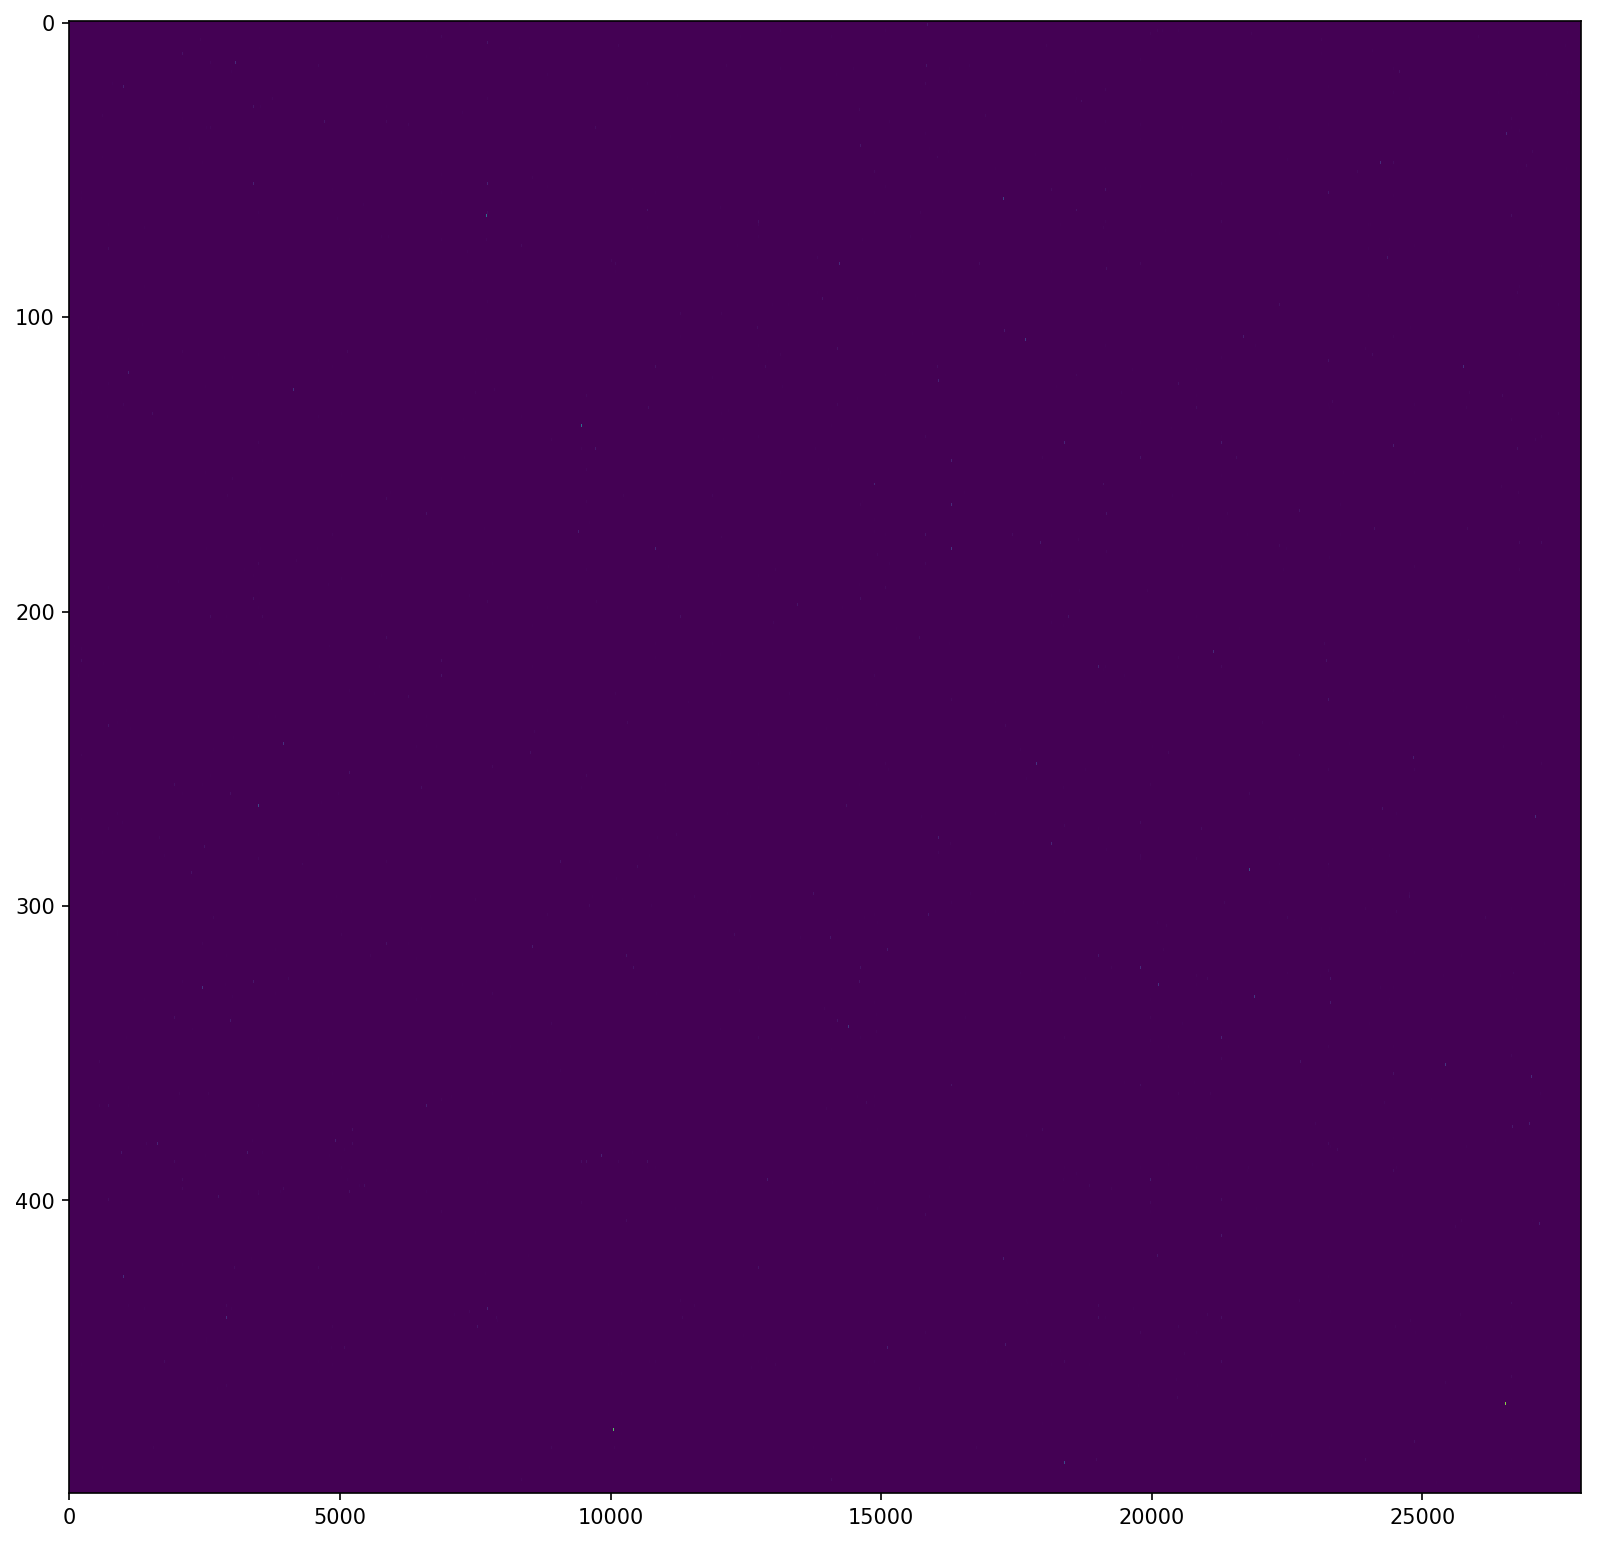

In [79]:
# use this for visualisation if necessary 
my_dpi=150
plt.figure(figsize=(2000/my_dpi, 2000/my_dpi), dpi=my_dpi)
plt.imshow(pivot_table_normalised, aspect="auto")

# GET ORIGINAL THETA(NORM GAMMA)

In [252]:
#get the original theta from the database for subsequent comparison 
# remember theta is jsut normalised gamma
theta = DocumentMass2Motif.objects.filter(document_id__in=document_id_list)
output_data_theta = []
for t in theta:
    output_data_theta.append([unique_docs[int(t.document_id)], unique_topics[int(t.mass2motif_id)], t.probability])
#checked if it is correct against the database

In [253]:
output_data_theta

[[0, 218, 0.990136521727459],
 [1, 413, 0.0122284803668866],
 [1, 164, 0.984625841740529],
 [2, 446, 0.973540791004048],
 [2, 413, 0.0262157498993542]]

# GET ORIGINAL PHI 

In [102]:
# get the features related to the instances
# i2f stands for instance to feature
i2f = FeatureInstance.objects.filter(document_id__in=document_id_list)
i2f_dict = {}
for i in i2f:
    i2f_dict.update({i.id: i.feature_id})
# checked against database works fine

In [242]:
# get the original phi from the database
phi = FeatureMass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
output_data_phi = []
for p in phi:
    word = int(p.featureinstance_id)
    doc = int(p.document_id)
    topic = int(p.mass2motif_id)
    if word in i2f_dict.keys(): 
        output_data_phi.append([unique_topics[topic], unique_words[i2f_dict[word]], p.probability])
#you will get topic index, word index, probability 

AttributeError: 'FeatureMass2MotifInstance' object has no attribute 'document_id'

In [231]:
output_data_phi_2[]

[[164, 9245, 1.0],
 [164, 14435, 1.0],
 [164, 16064, 1.0],
 [164, 15528, 1.0],
 [164, 11433, 1.0],
 [164, 4590, 1.0],
 [164, 19113, 1.0],
 [164, 5863, 1.0],
 [164, 1452, 1.0],
 [164, 16875, 1.0],
 [164, 20207, 1.0],
 [164, 19483, 1.0],
 [164, 11009, 1.0],
 [164, 8897, 1.0],
 [164, 5951, 1.0],
 [164, 12584, 1.0],
 [164, 1062, 1.0],
 [164, 6873, 0.0702070470035183],
 [164, 2492, 1.0],
 [164, 14979, 1.0],
 [164, 578, 1.0],
 [164, 19128, 1.0],
 [164, 18764, 1.0],
 [164, 19876, 1.0],
 [164, 17158, 1.0],
 [164, 23330, 1.0],
 [164, 7078, 1.0],
 [164, 22574, 1.0],
 [164, 14312, 1.0],
 [164, 19856, 1.0],
 [164, 16896, 1.0],
 [164, 20507, 1.0],
 [164, 7453, 1.0],
 [164, 12814, 1.0],
 [164, 7089, 0.998632372962815],
 [164, 21044, 1.0],
 [164, 14824, 1.0],
 [164, 14603, 1.0],
 [164, 17898, 1.0],
 [164, 13799, 1.0],
 [164, 1387, 1.0],
 [164, 14300, 1.0],
 [164, 7642, 1.0],
 [164, 22516, 1.0],
 [164, 24495, 1.0],
 [164, 4675, 1.0],
 [164, 22329, 1.0],
 [164, 10902, 0.0161172063016783],
 [164, 3687, 

# E-STEP (has 9 steps)

## Step 0 - E-step variables

In [199]:
# alpha_vector is already mentioned above
# beta_matrix is created here from pivot_table_normalised
# K and W are from above for total unique topics, total unique words respectively 
# you need a corpus (created above)
corpus = corpus_dict
beta_matrix = pivot_table_normalised

## Step 1 - Initialise phi

In [233]:
# initialise the 3D matrix phi
phi_matrix={}
for doc in corpus: 
    d = int(doc)
    phi_matrix[d] = {}
    for word in corpus[doc]:
        w = int(word)
        phi_matrix[d][w]=np.zeros(K)

In [234]:
phi_matrix

{0: {97: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Step 2 - initialise gamma 

In [201]:
gamma_vector = alpha_vector
#from the vector however we also need to create a gamma matrix with rows as documents and columns as topics 
#this will later be transposed in order to create the phi matrix in the steps 3-9 below
gamma_matrix=np.zeros((int(len(corpus)),int(K))) #3x500 shape
i = 0
max = int(len(document_id_list))
while i < max: 
    gamma_matrix[i,:] = alpha_vector 
    i+=1


In [235]:
gamma_matrix

array([[1.12123901e-100, 1.00000000e-100, 1.30572479e-100, ...,
        1.60731692e-100, 1.79764381e-100, 1.77700365e-100],
       [1.12123901e-100, 1.00000000e-100, 1.30572479e-100, ...,
        1.60731692e-100, 1.79764381e-100, 1.77700365e-100],
       [1.12123901e-100, 1.00000000e-100, 1.30572479e-100, ...,
        1.60731692e-100, 1.79764381e-100, 1.77700365e-100]])

## Step 3 - 9: repeat until convergence loop

In [249]:
# initialise phi and do Blei's loop
for doc in corpus:
    d = int(doc)
    doc_dict = corpus[doc]
    for word in doc_dict: #the word is actually column positioning so we do not need n^3 complexity 
        w = int(word)
        log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[d,:]).T
        log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
        phi_matrix[d][w] = log_phi_matrix/log_phi_matrix.sum()
    gamma_matrix[d,:] += phi_matrix[d][w]*corpus[doc][word]
    pos = np.where(gamma_matrix[d,:]<SMALL_NUMBER)[0]
    gamma_matrix[d,pos] = SMALL_NUMBER

      


In [250]:
gamma_matrix[0]

array([1.12123901e-100, 1.00000000e-100, 1.30572479e-100, 1.00000000e-100,
       1.33139133e-100, 1.34294648e-100, 1.23616731e-100, 1.36413643e-100,
       1.29121748e-100, 1.29121748e-100, 1.12124171e-100, 1.40091687e-100,
       1.38331010e-100, 1.17702780e-100, 1.17702780e-100, 1.00000000e-100,
       1.00000000e-100, 1.31903950e-100, 1.17702788e-100, 1.21072307e-100,
       1.51526781e-100, 1.39228762e-100, 1.12160536e-100, 1.39228762e-100,
       1.00000000e-100, 1.17702781e-100, 1.25711884e-100, 1.12124719e-100,
       1.00000000e-100, 1.48619482e-100, 1.30572479e-100, 1.21072307e-100,
       1.43989020e-100, 1.00000000e-100, 1.17702790e-100, 1.12124320e-100,
       1.29121748e-100, 1.23616731e-100, 1.23616731e-100, 1.00000000e-100,
       1.17702780e-100, 1.42503687e-100, 1.31903950e-100, 1.27518542e-100,
       1.23616731e-100, 1.00000000e-100, 1.25711884e-100, 1.37394298e-100,
       1.43257255e-100, 1.30572479e-100, 1.00000000e-100, 1.30572479e-100,
       1.29121748e-100, 1

In [124]:
# def e_step(K, n_words, corpus): 
#     temp_beta = np.zeros((K,n_words)) 
#     for doc in corpus: 
#         d = doc_index[doc]
#         temp_gamma = np.zeros(K) + alpha
#         for word in corpus[doc]: 
#             w = word_index[word]
#             log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[d,:]).T #transpose of the matrix
#             log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
#             phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
#             temp_gamma += phi_matrix[doc][word]*corpus[doc][word]
#             temp_beta[:,w] += phi_matrix[doc][word] * corpus[doc][word]
#         gamma_matrix[d,:] = temp_gamma
#         pos = np.where(gamma_matrix[d,:]<SMALL_NUMBER)[0]
#         gamma_matrix[d,pos] = SMALL_NUMBER

# OTHER STUFF

In [49]:
corpus = corpus_dict
n_docs = len(corpus)
K = 499
alpha = 0.1


In [50]:
# get the doc index + word index dictionaries - you will need them for e-step
doc_index = {}
word_index = {}
doc_pos = 0
word_pos = 0
for doc in corpus:
    doc_index[doc] = doc_pos
    doc_pos += 1
    for word in corpus[doc]:
        if not word in word_index:
            word_index[word] = word_pos
            word_pos += 1
n_words=word_pos
beta_matrix=np.load('beta_pivot3_ext.npy')

In [52]:
#STUCK HERE
gamma_matrix = np.zeros((n_docs, K))
gamma_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
phi = np.zeros((K,n_words)) + (1.0/K)


In [53]:
# the estep implementation by SIMON&AL. - topics, words and corpus -  this is finding the optimizing values of the variational parameters

from scipy.special import polygamma as pg
from scipy.special import psi as psi

def e_step(K, n_words, corpus): 
    temp_beta = np.zeros((K,n_words)) 
    for doc in corpus: 
        d = doc_index[doc]
        temp_gamma = np.zeros(K) + alpha
        for word in corpus[doc]: 
            w = word_index[word]
            log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[d,:]).T
            log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
            phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
            temp_gamma += phi_matrix[doc][word]*corpus[doc][word]
            temp_beta[:,w] += phi_matrix[doc][word] * corpus[doc][word]
        gamma_matrix[d,:] = temp_gamma
        pos = np.where(gamma_matrix[d,:]<SMALL_NUMBER)[0]
        gamma_matrix[d,pos] = SMALL_NUMBER

e_step(K, n_words, corpus)


c:\users\rpetr\.virtualenvs\diss_code-vdgvikwu\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in subtract
  


NameError: global name 'phi_matrix' is not defined

try to undrstand the following code for just one doc and one word

In [ ]:
temp_gamma += phi_matrix[doc][word]*corpus[doc][word]
temp_beta[:,w] += phi_matrix[doc][word] * corpus[doc][word]

TypeError: int() argument must be a string or a number, not 'dict'

In [40]:

#     gamma_matrix[d,:] = temp_gamma
#     pos = np.where(gamma_matrix[d,:]<SMALL_NUMBER)[0]
#     gamma_matrix[d,pos] = SMALL_NUMBER
gamma_matrix = np.zeros((n_docs, K))
for doc in corpus:
    doc_total = 0.0
    for word in corpus[doc]:
        doc_total += corpus[doc][word]
    gamma_matrix[d,:] = alpha + 1.0*doc_total/K
    
gamma_matrix[d,:]

NameError: name 'd' is not defined

In [ ]:
 def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]